In [3]:
import os 
import sys
import re 
import numpy as np
import agilent_loader as ag
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings
import PyMi as pmi

folder = "GL1"

results_folder = folder+"\\Results"

pmi.check_and_prepare_folder(results_folder)

files_in_folder = pmi.get_mi_files_in_folder(folder)

print(f" Found {len(files_in_folder)} files in {folder}")


Folder 'GL1\Results' already exists and is now empty.
 Found 1 files in GL1


2
graphing topography
2 200
200 scale length 200
showing


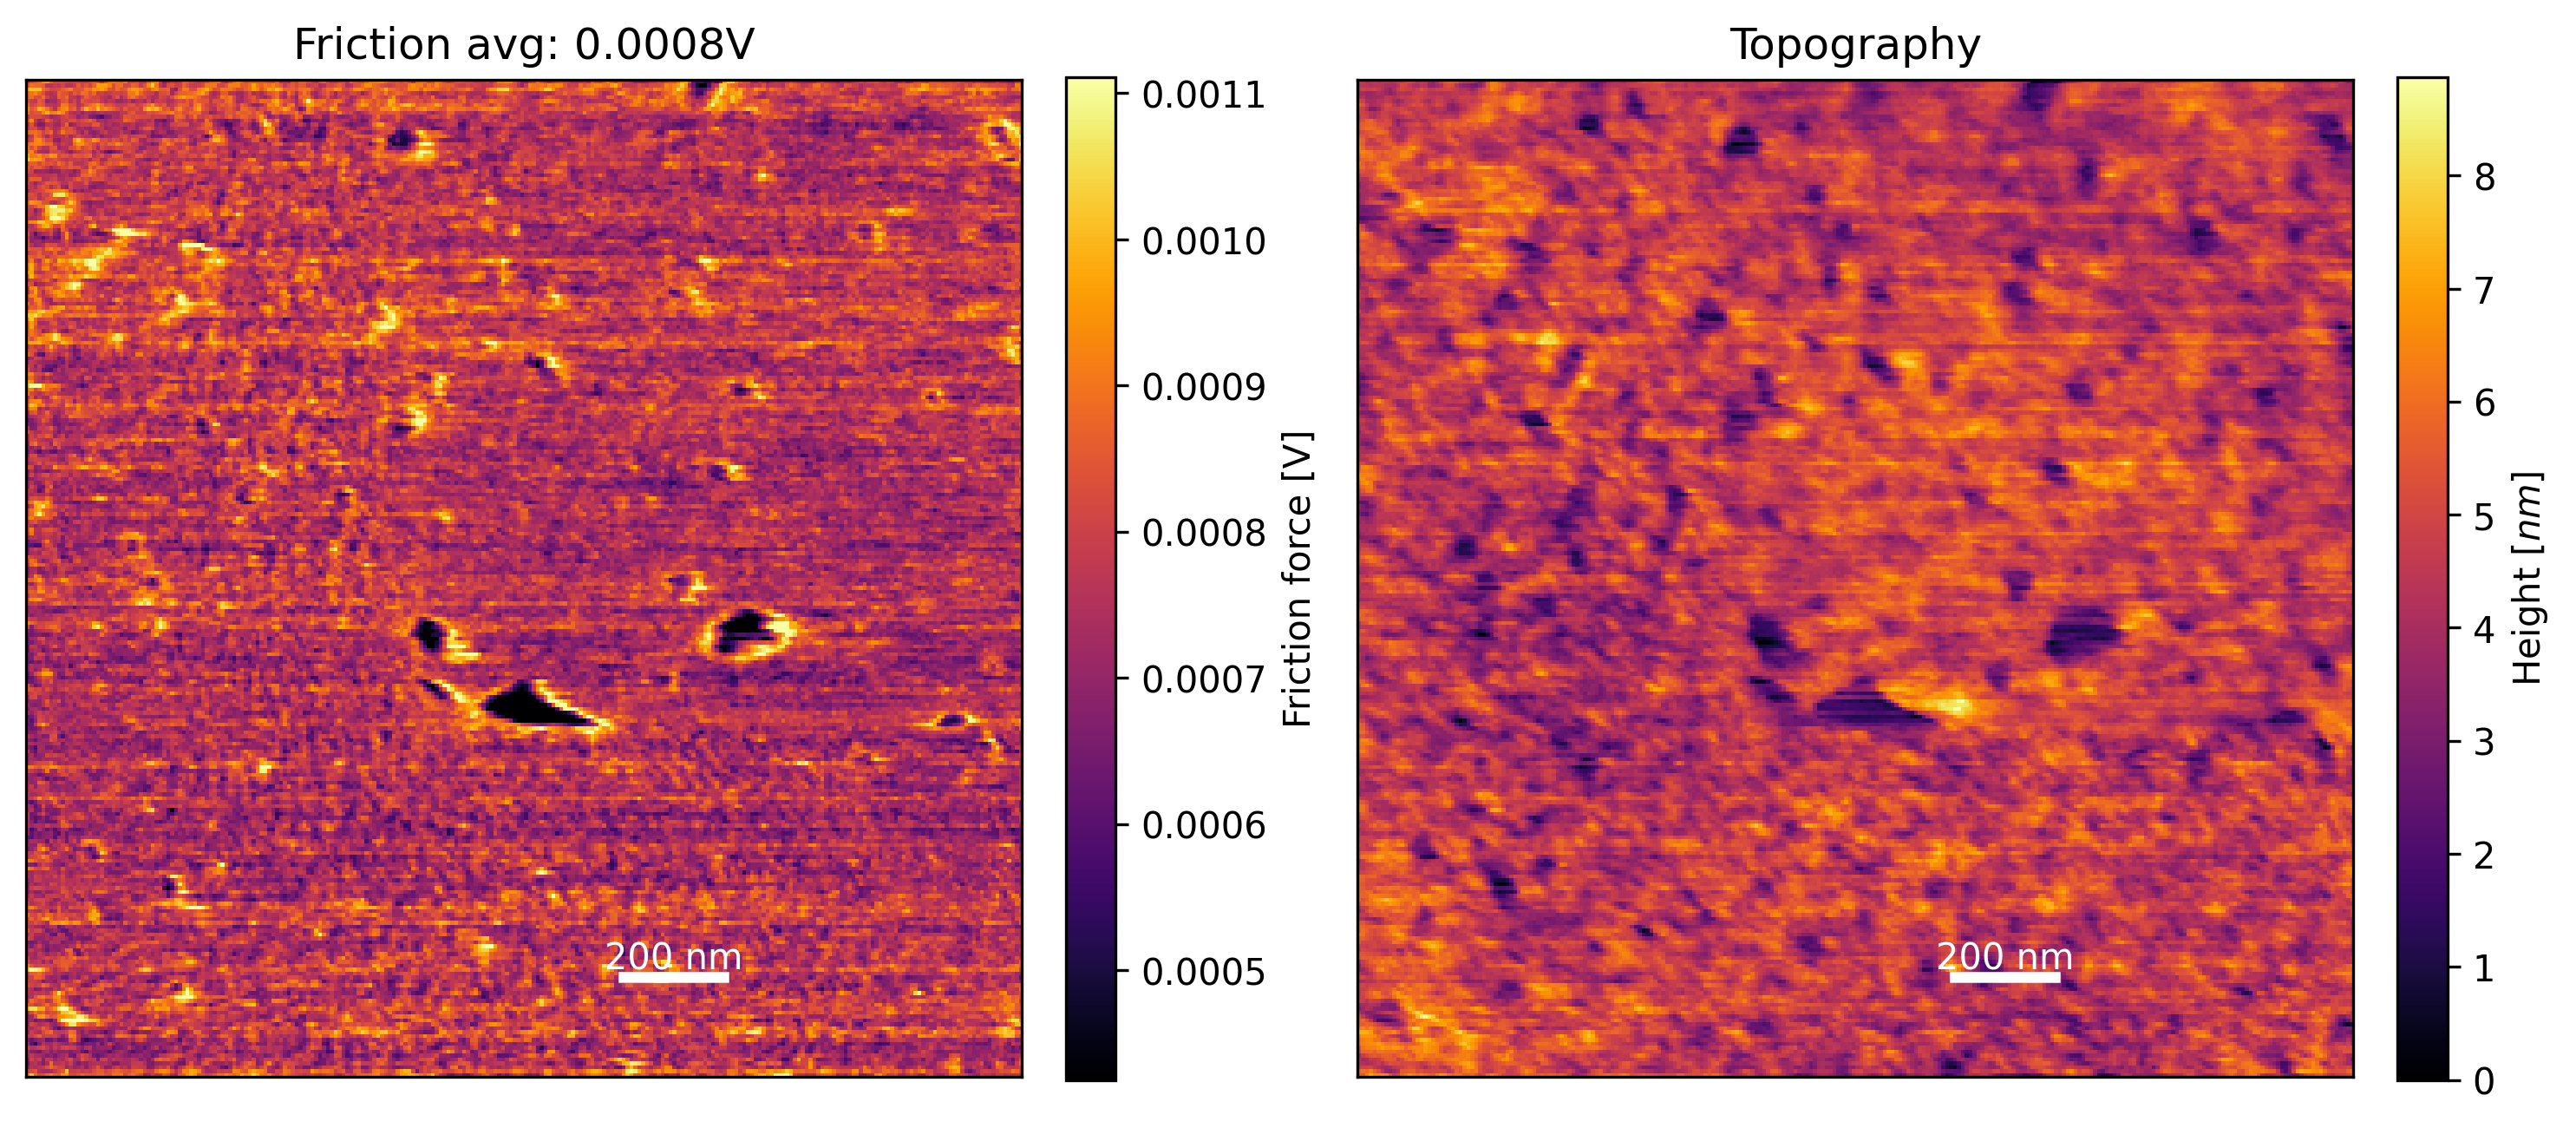

In [5]:
Cof_for_runs=np.zeros(len(files_in_folder))
Cof_for_runs_std=np.zeros(len(files_in_folder))
ii=0



canteliever_length=450		#[um]
canteliever_width=50		#[um]
canteliever_height=15e-3	#[um]
poisson_ratio=0.28


spring_constant=0.35	#[N/m]
InVOLS=100				#[nm/V]
Torsional_k=1.75e-10	#[Nm]
lateral_sensitivity=1.75e-10	#[nm/V]




K_l=2*spring_constant*canteliever_length**2/ (3*(1+poisson_ratio)*canteliever_height**2)	#[N/m]

#!↑↑↑ This is the formula for the lateral spring constant, for the Sader and Green methods


conversion_factor_alpha=spring_constant*InVOLS




scale_length=200

multiple_files=False
if len(files_in_folder)>2:
	multiple_files=True


for file_path in files_in_folder:
	
	file=ag.load_mi(folder+"\\"+file_path)	
	
	
	Normal_force=conversion_factor_alpha*file.servoSetpoint




	results_buffers= pmi.load_buffers_from_file(file)
	print(len(results_buffers))
	if len(results_buffers)==2:
		friction_arrays,topography_arrays=results_buffers
	if len(results_buffers)==3:
		friction_arrays,topography_arrays,current_arrays=results_buffers

	averaged_friction,Cof_for_runs[ii],Cof_for_runs_std[ii]=pmi.calculate_CoF(friction_arrays,file_path,K_l*lateral_sensitivity )
		
	if (ii==0) :
		
		pmi.graph_friction_n_topography( 
								file=file,
								averaged_friction=averaged_friction,
								topography=topography_arrays[0],
								results_folder=results_folder,
								file_path=file_path,
								title="Friction and Topography", 
								show=True, 
								scale_length=scale_length,
								friction_color_range=4,
								bar_position=(0.6,0.1), 
								scale_unit="nm",
								axis_ticks=False,
								)
		


		
	elif not multiple_files:
		# print("Only one file in folder, skipping plotting")
		pmi.graph_friction_n_topography(file,averaged_friction,topography_arrays[0],results_folder,file_path,"Friction and Topography", show=False, scale_length=scale_length)
	ii+=1


if multiple_files:

	pmi.plot_CoF(Cof_for_runs,Cof_for_runs_std,results_folder, show=True)





